Saved: /home/greenhamlab/snTC/20240411.GRNs.ParallelShuffled/Figures/20250522.Jaccard.GlobalGRNs.pdf


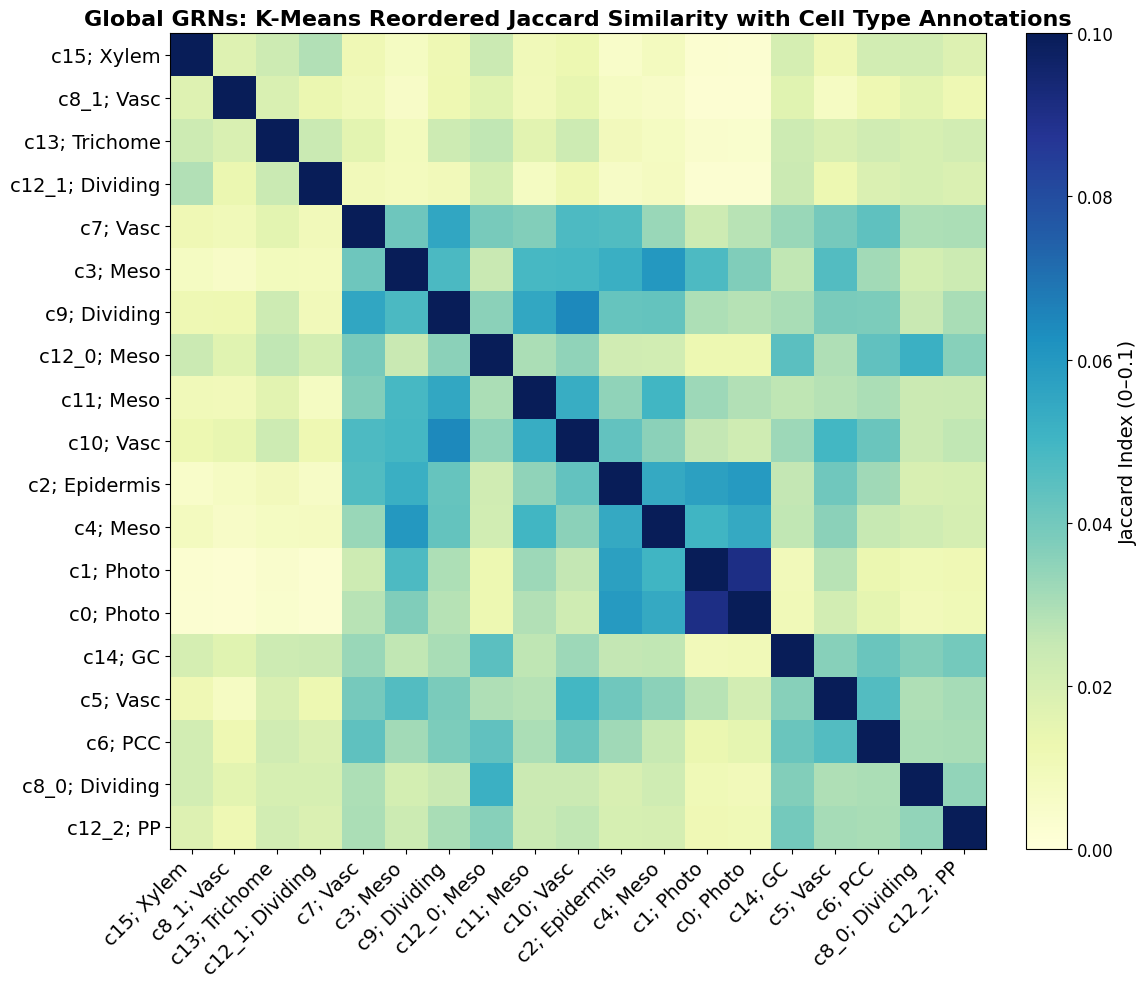

Saved: /home/greenhamlab/snTC/20240411.GRNs.ParallelShuffled/Figures/20250522.Jaccard.CCA1only.pdf


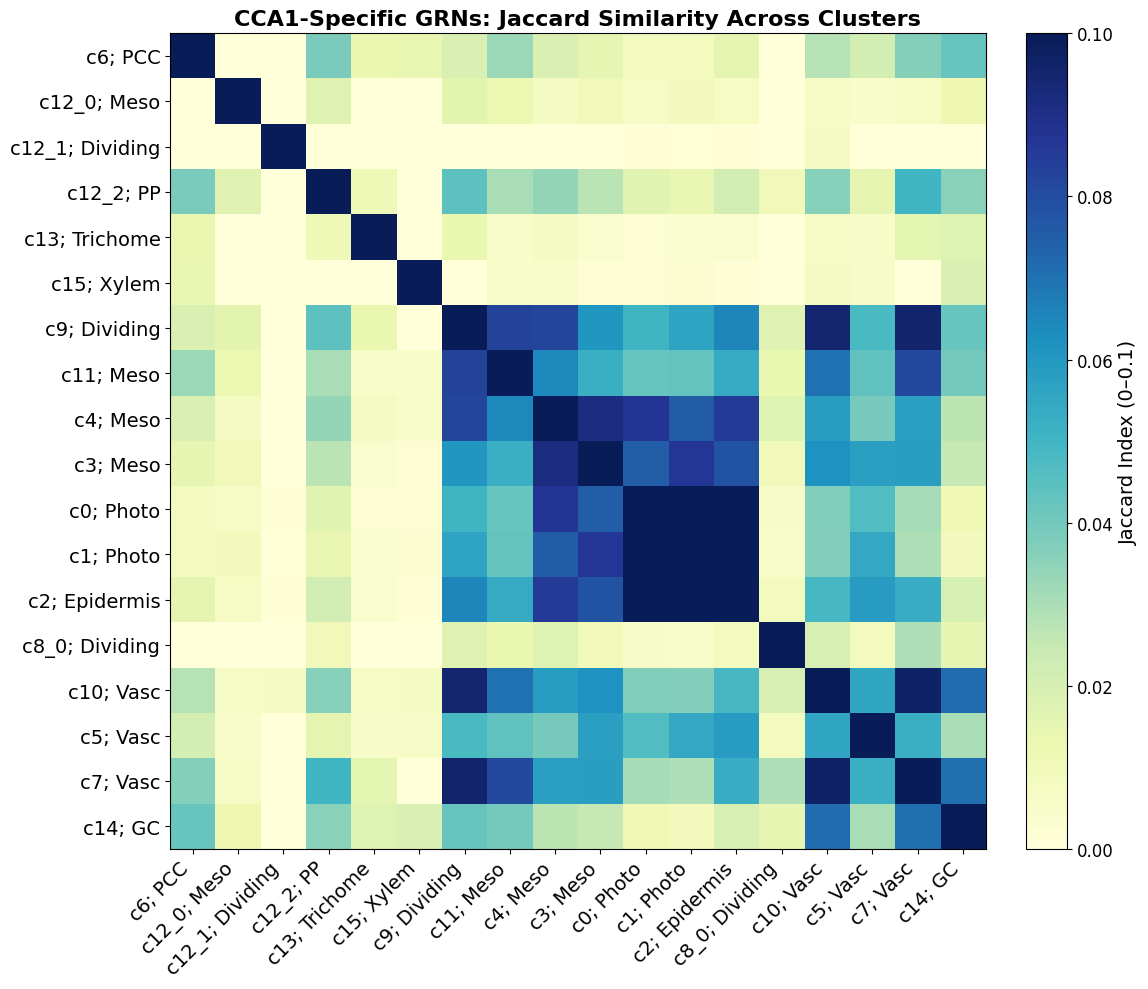

In [1]:
# %% [markdown]
# ## Jaccard Similarity Heatmaps: Global and CCA1-Specific GRNs

# %% [code]
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from matplotlib.backends.backend_pdf import PdfPages

# Load GRN data
df_all = pd.read_csv(
    "/home/greenhamlab/snTC/20240411.GRNs.ParallelShuffled/all_adj/unshuffled_top95_all_clusters.tsv",
    sep="\t",
    usecols=["cluster", "TF", "target"]
)

# Define cluster order
clusters = sorted(df_all["cluster"].unique())

# Map cluster to predicted cell types (shortened names)
celltype_map = {
    "0": "Photo", "1": "Photo", "5": "Vasc", "2": "Epidermis", "11": "Meso", "3": "Meso", "4": "Meso",
    "12_2": "PP", "10": "Vasc", "9": "Dividing", "14": "GC", "6": "PCC", "12_0": "Meso",
    "7": "Vasc", "8_0": "Dividing", "12_1": "Dividing", "13": "Trichome", "8_1": "Vasc",
    "16": "Root Hair", "15": "Xylem"
}
def annotate(cluster):
    base = cluster.replace("c", "") if cluster.startswith("c") else cluster
    return f"{cluster}; {celltype_map.get(base, 'Unknown')}"

# Function to compute Jaccard matrix and plot
def compute_jaccard_plot(df, tf_filter=None, title="", output_pdf=""):
    if tf_filter:
        df = df[df["TF"] == tf_filter]

    grn_sets = {
        cluster: set(zip(group["TF"], group["target"]))
        for cluster, group in df.groupby("cluster")
    }

    cluster_list = sorted(grn_sets.keys())
    n = len(cluster_list)
    jacc = np.zeros((n, n))
    for i, c1 in enumerate(cluster_list):
        for j, c2 in enumerate(cluster_list):
            s1, s2 = grn_sets[c1], grn_sets[c2]
            union = s1 | s2
            jacc[i, j] = len(s1 & s2) / len(union) if union else np.nan

    jacc_df = pd.DataFrame(jacc, index=cluster_list, columns=cluster_list)

    # Reorder using K-means
    kmeans = KMeans(n_clusters=min(4, n), random_state=42).fit(jacc_df.values)
    order = np.argsort(kmeans.labels_)
    ordered = [cluster_list[i] for i in order]
    jacc_ordered = jacc_df.loc[ordered, ordered]
    annotated_labels = [annotate(c) for c in ordered]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(jacc_ordered.values, aspect='equal', vmin=0, vmax=0.1, cmap='YlGnBu')
    ax.set_xticks(range(n))
    ax.set_xticklabels(annotated_labels, rotation=45, fontsize=14, ha='right')
    ax.set_yticks(range(n))
    ax.set_yticklabels(annotated_labels, fontsize=14)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Jaccard Index (0–0.1)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    ax.set_title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

    # Save as PDF
    fig.savefig(output_pdf, dpi=300)
    print(f"Saved: {output_pdf}")
    plt.show()

# %% [code]
# Plot 1: Global Network Jaccard Similarity
compute_jaccard_plot(
    df=df_all,
    tf_filter=None,
    title="Global GRNs: K-Means Reordered Jaccard Similarity with Cell Type Annotations",
    output_pdf="/home/greenhamlab/snTC/20240411.GRNs.ParallelShuffled/Figures/20250522.Jaccard.GlobalGRNs.pdf"
)

# %% [code]
# Plot 2: CCA1-specific Network Jaccard Similarity
compute_jaccard_plot(
    df=df_all,
    tf_filter="AT2G46830",
    title="CCA1-Specific GRNs: Jaccard Similarity Across Clusters",
    output_pdf="/home/greenhamlab/snTC/20240411.GRNs.ParallelShuffled/Figures/20250522.Jaccard.CCA1only.pdf"
)
